In [2]:
import os, sys, json, random, math
sys.path.append('..')
sys.path.append('../../generative-models-main/')

import numpy as np
import pandas as pd
from tqdm import tqdm
from numpyencoder import NumpyEncoder
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import utils
import plot

from models import *
from GEFcom2014.forecast_quality import quantiles_and_evaluation
from GEFcom2014.models import scale_data_multi, plot_loss
from GEFcom2014.utils import dump_file

def concatenate_arrays(*arrays):
    concatenated = None
    for arr in arrays:
        if concatenated is None:
            concatenated = arr
        if arr.ndim == 1:
            concatenated = np.concatenate((concatenated, [arr]))
        if arr.ndim == 2:
            concatenated = np.concatenate((concatenated, arr))
        if arr.ndim == 3:
            concatenated = np.concatenate((concatenated, np.reshape(arr,(arr.shape[0],-1))))

    return concatenated

def predict_NF(model, config, attr, n=250,device='cuda'):
  return model.invert(z=torch.randn(n, config['conditioner_args']['in_size']).to(device), context=torch.tensor(np.tile(attr, n).reshape(n, config['conditioner_args']['cond_in'])).to(device).float()).cpu().detach().numpy()

# 0. Get test_data & load Model

In [3]:
CONFIG_PATH = r'C:\Thesis\scripts\normalizing-flows\runs\run4\UMNN_M.json'
MODEL_PATH = r'C:\Thesis\scripts\normalizing-flows\runs\run4\best_model.pt'

scaler = StandardScaler()
scaler_a = MinMaxScaler((0,1))

train_f, train_a = utils.get_training_data()
scaler.fit(train_f)
scaler_a.fit(train_a)

train_f_norm = scaler.transform(train_f)
train_a_norm = scaler_a.transform(train_a)
train_loader = DataLoader(utils.CustomDataset(torch.tensor(train_f_norm,dtype=torch.float32),
                                        torch.tensor(train_a_norm,dtype=torch.float32)),
                                        batch_size=200, 
                                        shuffle=True)

val_f, val_a = utils.get_validation_data()
val_f_norm = scaler.transform(val_f)
val_a_norm = scaler_a.transform(val_a)
val_loader = DataLoader(utils.CustomDataset(torch.tensor(val_f_norm,dtype=torch.float32),
                                        torch.tensor(val_a_norm,dtype=torch.float32)),
                                        batch_size=200, 
                                        shuffle=True)

test_f, test_a = utils.get_test_data()
test_f_norm = scaler.transform(test_f)
test_a_norm = scaler_a.transform(test_a)
test_loader = DataLoader(utils.CustomDataset(torch.tensor(test_f_norm,dtype=torch.float32),
                                        torch.tensor(test_a_norm,dtype=torch.float32)),
                                        batch_size=200, 
                                        shuffle=True)

with open(CONFIG_PATH) as f:
  config_file = json.load(f)

model = torch.load(MODEL_PATH).to(device)


def get_season(season):
  if season == 0: return 'Autumn'
  elif season == 1: return 'Spring'
  elif season == 2: return 'Summer'
  return 'Winter'
def print_attribute(attr):
  season = np.argmax(attr[4:8])
  season = get_season(season)
  weekend = np.argmax(attr[8:])
  weekend = 'False' if weekend == 0 else 'True'
  frame = pd.DataFrame({'Yearly Offtake': [attr[0]],
                        'Yearly Injection': [attr[1]],
                        'FeelsLikeC': [attr[2]],
                        'SunHours': [attr[3]],
                        'Season':[season],
                        'Weekend':[weekend]})
  print(frame)


# 5  different attributes used to compare evaluation methods. For each 250 similar days are search for in the test_set (OR FULL DATASET?), also 250 random samples are drawn from the test_set to compare as baseline
attributes = [test_a[0], test_a[100], test_a[300], test_a[3000], test_a[400]]
attributes_norm = [test_a_norm[0], test_a_norm[300], test_a_norm[200], test_a_norm[3000], test_a_norm[400]]
features = [utils.get_similar_days(test_f, test_a_norm, attr, 250) for attr in attributes_norm]
features_norm = [utils.get_similar_days(test_f, test_a_norm, attr, 250) for attr in attributes_norm]

print('Generating new samples:')
generated_norm = [predict_NF(model,config_file,attr,250) for attr in tqdm(attributes_norm)]
generated = [scaler.inverse_transform(gen) for gen in generated_norm]
random_samples = utils.get_random_days(test_f)

for attr in attributes: print_attribute(attr)

Generating new samples:


100%|██████████| 5/5 [02:00<00:00, 24.16s/it]

   Yearly Offtake  Yearly Injection  FeelsLikeC  SunHours  Season Weekend
0     3919.526247       2364.090251        -2.0       3.0  Winter   False
   Yearly Offtake  Yearly Injection  FeelsLikeC  SunHours  Season Weekend
0     2253.571749               0.0        22.0      14.5  Summer   False
   Yearly Offtake  Yearly Injection  FeelsLikeC  SunHours  Season Weekend
0     4255.872232               0.0        -1.0       3.1  Autumn    True
   Yearly Offtake  Yearly Injection  FeelsLikeC  SunHours  Season Weekend
0     4464.558243       3609.911248         5.0       8.3  Autumn   False
   Yearly Offtake  Yearly Injection  FeelsLikeC  SunHours  Season Weekend
0     3848.634998               0.0         5.0       8.8  Spring    True


# 1. T-SNE

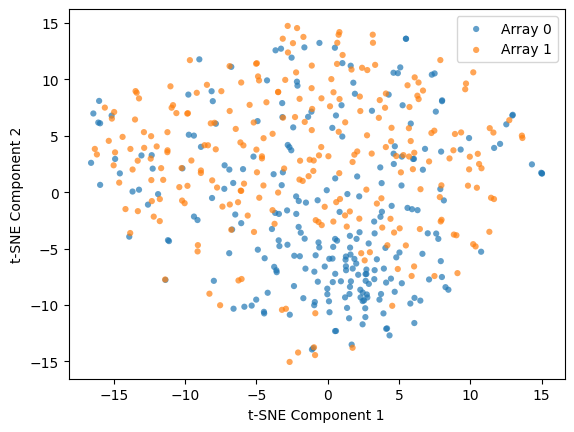

In [185]:
# Combine the arrays into a single dataset
data = (features[1],generated[1])
dataset = np.concatenate(data, axis=0)

tsne = TSNE(n_components=2, perplexity=30,random_state=42)
tsne_result = tsne.fit_transform(dataset)
tsne_split = np.array_split(tsne_result,len(data))

# Plot the t-SNE
for i, tsnei in enumerate(tsne_split):
    plt.scatter(tsnei[:, 0], tsnei[:, 1], alpha=0.7, s=20, edgecolor='none', label=f'Array {i}')
# plt.scatter(tsne2[:, 0], tsne2[:, 1], label='Array 2')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# 2. Autocorellation

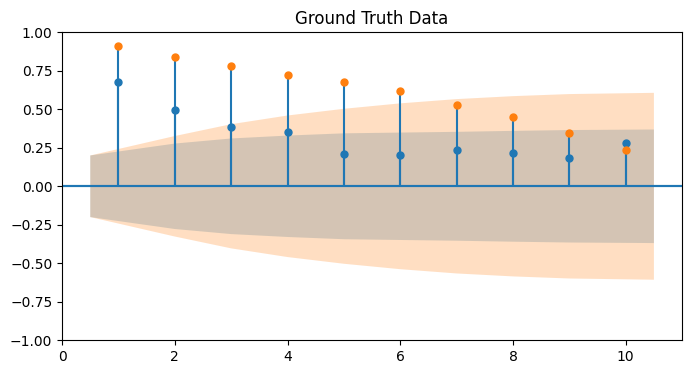

In [187]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
# Compute ACF of both time series
lags = 10
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(generated[0][0], lags=lags, alpha=0.05, title="Ground Truth Data",ax=ax, zero=False)
plot_acf(features[0][0], lags=lags, alpha=0.05, title="Ground Truth Data",ax=ax, zero=False)
plt.show()

# 3. Load duration curves

In [188]:
def calculate_loadcurve(timeserie):
    timeserie = timeserie.copy()
    shift = np.abs(np.min(timeserie)) + 1e-6
    ts_shifted = timeserie + shift
    ts_sorted = np.sort(ts_shifted)[::-1]
    # Compute the cumulative probability of occurrence for each data point
    cdf = np.cumsum(ts_sorted) / np.sum(ts_sorted)
    return cdf, ts_sorted

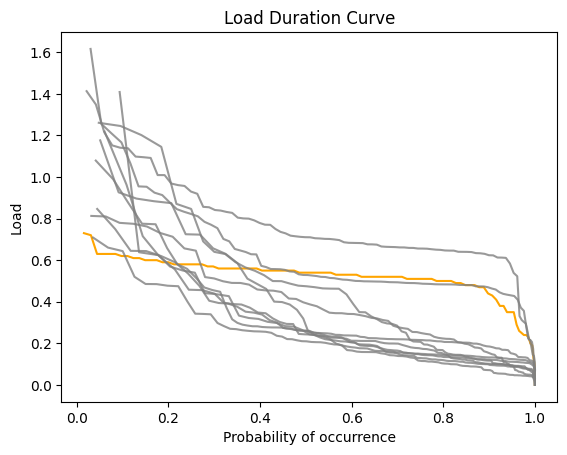

In [197]:
cdf, ts_sorted = calculate_loadcurve(features[0][0])
fig, ax = plt.subplots()
ax.plot(cdf, ts_sorted,c='orange')

for sam in generated[0][0:10]:
    cdf, ts_sorted = calculate_loadcurve(sam)
    ax.plot(cdf, ts_sorted,c='gray',alpha=0.8)

# Plot the load duration curve
ax.set_xlabel('Probability of occurrence')
ax.set_ylabel('Load')
ax.set_title('Load Duration Curve')
plt.show()

# 3.1 Mean load curves

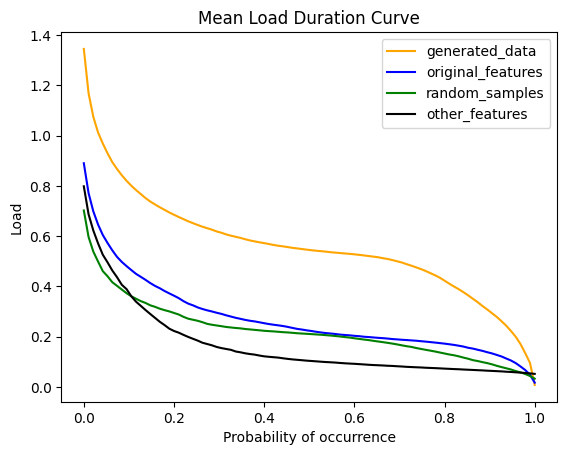

In [193]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots()

# Calculate the LDC for each time series
ldcs = []
for ts in generated[3]:
    cdf, ts_sorted = calculate_loadcurve(ts)
    ldcs.append(ts_sorted)

mean_ldc = np.mean(ldcs, axis=0)

ax.plot(np.linspace(0, 1, len(mean_ldc)), mean_ldc, c='orange',label='generated_data')

# for ts in features[0][0:10]:
#     cdf, ts_sorted = calculate_loadcurve(ts)
#     ax.plot(cdf, ts_sorted, c='gray', alpha=0.8)

ldcs = []
for ts in features[0]:
    cdf, ts_sorted = calculate_loadcurve(ts)
    ldcs.append(ts_sorted)

mean_ldc = np.mean(ldcs, axis=0)
ax.plot(np.linspace(0, 1, len(mean_ldc)), mean_ldc, c='blue',label='original_features')

ldcs = []
for ts in random_samples:
    cdf, ts_sorted = calculate_loadcurve(ts)
    ldcs.append(ts_sorted)

mean_ldc = np.mean(ldcs, axis=0)
ax.plot(np.linspace(0, 1, len(mean_ldc)), mean_ldc, c='green',label='random_samples')

ldcs = []
for ts in features[2]:
    cdf, ts_sorted = calculate_loadcurve(ts)
    ldcs.append(ts_sorted)

mean_ldc = np.mean(ldcs, axis=0)
ax.plot(np.linspace(0, 1, len(mean_ldc)), mean_ldc, c='black',label='other_features')

# Plot the load duration curve
ax.set_xlabel('Probability of occurrence')
ax.set_ylabel('Load')
ax.set_title('Mean Load Duration Curve')
ax.legend()
plt.show()

#kernel density estimation

# 4. Quantile plots

In [198]:
def create_quantile_plot(time_series,single_time_series=None):
    from matplotlib.colors import ListedColormap, Normalize
    from matplotlib.cm import ScalarMappable
    quantiles = np.arange(0.05,1,0.05)
    time_series_quantiles = np.quantile(time_series,quantiles,axis=0)
    timestamps = np.arange(time_series_quantiles.shape[1])
    cmap = plt.get_cmap('Blues', len(quantiles)//1.5)
    for i in range(len(quantiles)-1):
        color_idx = i if i < len(quantiles) // 2 else len(quantiles) - 2 - i
        plt.fill_between(timestamps, time_series_quantiles[i], time_series_quantiles[i + 1],
                     color=cmap(color_idx + 1), alpha=1)

    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('Time Series Quantiles (5-95)')

    # Set up the color bar
    custom_cmap = ListedColormap(cmap(np.arange(1, cmap.N)))
    norm = Normalize(vmin=5, vmax=95)
    sm = ScalarMappable(norm=norm, cmap=custom_cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(5, 95, 19))
    cbar.ax.set_yticklabels([f'{int(q * 100)}%' for q in quantiles])
    if single_time_series is not None:
        plt.plot(single_time_series,c='orange')
    plt.show()

C:\Users\jankr\AppData\Local\Temp\ipykernel_14060\307025753.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(5, 95, 19))


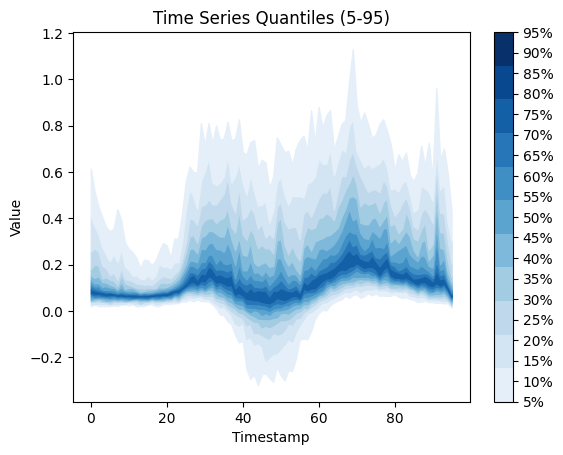

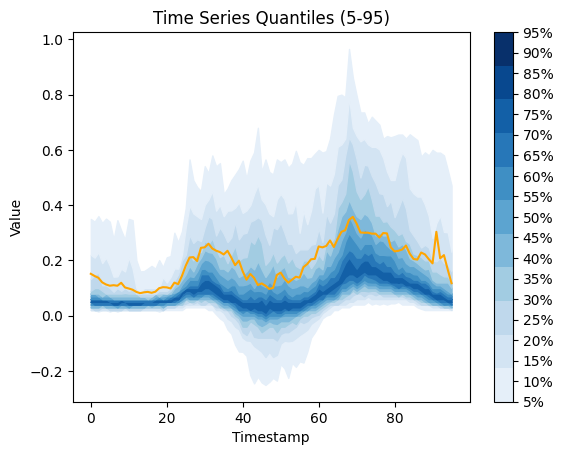

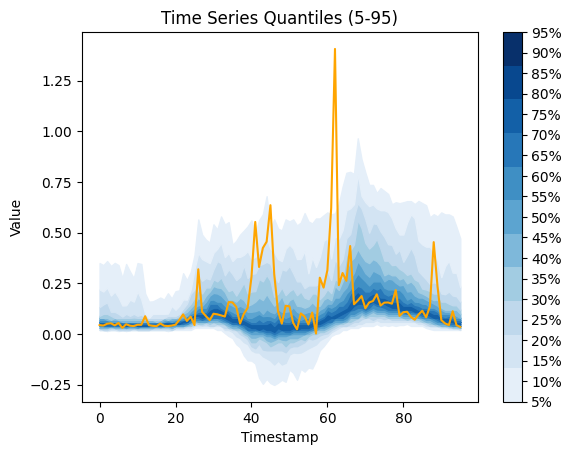

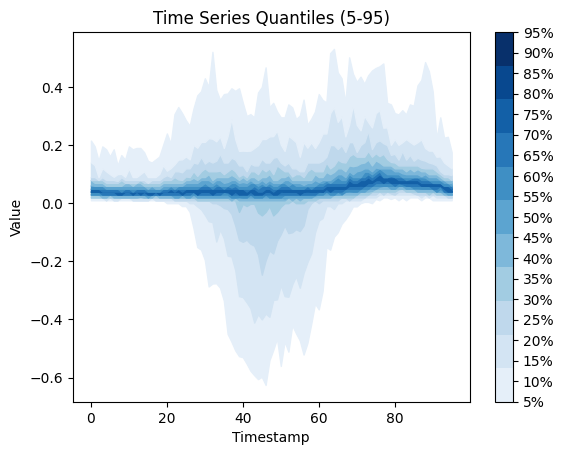

In [199]:
create_quantile_plot(generated[0]) # features[0][3]
create_quantile_plot(features[0], np.mean(generated[0],axis=0))
create_quantile_plot(features[0], generated[0][5])
create_quantile_plot(random_samples)

C:\Users\jankr\AppData\Local\Temp\ipykernel_14060\1915339148.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 100, len(quantiles)+1))


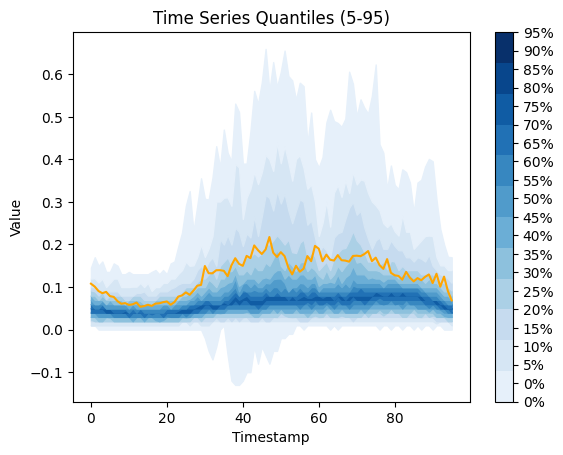

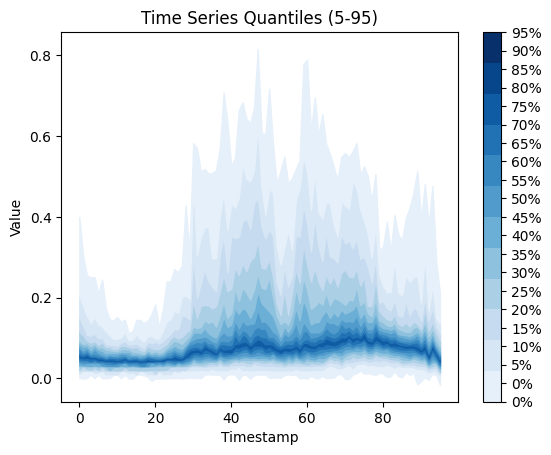

In [132]:
create_quantile_plot(features[4], np.mean(generated[4],axis=0))
create_quantile_plot(generated[4])

In [205]:
def percentage_of_data_for_each_quantile(time_series, new_timeserie):
    quantiles = np.arange(0.0,1.01,0.05)
    time_series_quantiles = np.quantile(time_series,quantiles,axis=0)
    count_within_quantiles = np.zeros(len(quantiles)-1,dtype=int)
    for i in range(len(quantiles)-1):
        within_range = np.logical_and(new_timeserie >= time_series_quantiles[i],
                                      new_timeserie <= time_series_quantiles[i+1])
        count_within_quantiles[i] = np.sum(within_range)
    
    return count_within_quantiles / len(new_timeserie) * 100

In [210]:
# Now compute how well the data falls inside the quantiles!
percentage_within_quantiles = percentage_of_data_for_each_quantile(generated[0], 
                                                                   features[4][0])
quantiles = np.arange(0.0,1.01,0.05)
for i in range(len(quantiles) - 1):
    print(f'{int(quantiles[i] * 100)}-{int(quantiles[i + 1] * 100)}% Quantile: {percentage_within_quantiles[i]:.2f}%')

0-5% Quantile: 15.62%
5-10% Quantile: 11.46%
10-15% Quantile: 7.29%
15-20% Quantile: 9.38%
20-25% Quantile: 10.42%
25-30% Quantile: 6.25%
30-35% Quantile: 6.25%
35-40% Quantile: 4.17%
40-45% Quantile: 6.25%
45-50% Quantile: 4.17%
50-55% Quantile: 7.29%
55-60% Quantile: 4.17%
60-65% Quantile: 0.00%
65-70% Quantile: 3.12%
70-75% Quantile: 1.04%
75-80% Quantile: 1.04%
80-85% Quantile: 0.00%
85-90% Quantile: 0.00%
90-95% Quantile: 0.00%
95-100% Quantile: 0.00%


# 5. Maximum Mean Discrepancy

https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html


In [214]:
import numpy as np

def gaussian_kernel(x, y, sigma=1):
    return np.exp(-np.sum((x - y) ** 2) / (2 * sigma ** 2))

def mmd(X, Y, kernel=gaussian_kernel, sigma=1):
    n, m = len(X), len(Y)
    
    # Compute pairwise kernel values
    XX = np.array([[kernel(x1, x2, sigma) for x2 in X] for x1 in X])
    YY = np.array([[kernel(y1, y2, sigma) for y2 in Y] for y1 in Y])
    XY = np.array([[kernel(x, y, sigma) for y in Y] for x in X])

    # Calculate MMD
    mmd_value = np.sum(XX) / (n * (n - 1)) + np.sum(YY) / (m * (m - 1)) - 2 * np.sum(XY) / (n * m)
    return mmd_value

mmd_value = mmd(generated[0], features[0][0])
print(f'MMD value: {mmd_value:.4f}')

mmd_value = mmd(generated[0], random_samples[0])
print(f'MMD value: {mmd_value:.4f}')

mmd_value = mmd(generated[0], features[1][0])
print(f'MMD value: {mmd_value:.4f}')

MMD value: 0.8034
MMD value: 0.8302
MMD value: 0.7644


In probability theory and statistics, the Jensen–Shannon divergence is a method of measuring the similarity between two probability distributions. It is also known as information radius (IRad)or total divergence to the average.

# 6. Energy Score

In [215]:
probality_array = [1/250]*250
scores = np.mean([utils.calculate_energy_score(probality_array,generated[0], profile) for profile in features[0]])
print(f'Energy score: {scores:.4f}')

probality_array = [1/250]*250
scores = np.mean([utils.calculate_energy_score(probality_array,generated[1], profile) for profile in features[1]])
print(f'Energy score: {scores:.4f}')

probality_array = [1/250]*250
scores = np.mean([utils.calculate_energy_score(probality_array,random_samples, profile) for profile in features[0]])
print(f'Energy score: {scores:.4f}')

Energy score: 1.3095
Energy score: 1.1842
Energy score: 1.3670


# 7. MSE, MAE, RMSE

In [218]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(generated[0],features[0])
mae = mean_absolute_error(generated[0],features[0])
rmse = np.sqrt(mse)

# Print the results
print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

mse = mean_squared_error(generated[0],features[1])
mae = mean_absolute_error(generated[0],features[1])
rmse = np.sqrt(mse)

# Print the results
print('')
print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

mse = mean_squared_error(generated[0],random_samples)
mae = mean_absolute_error(generated[0],random_samples)
rmse = np.sqrt(mse)

# Print the results
print('')
print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

ValueError: Found input variables with inconsistent numbers of samples: [250, 96]

# 8. Pearson correlation

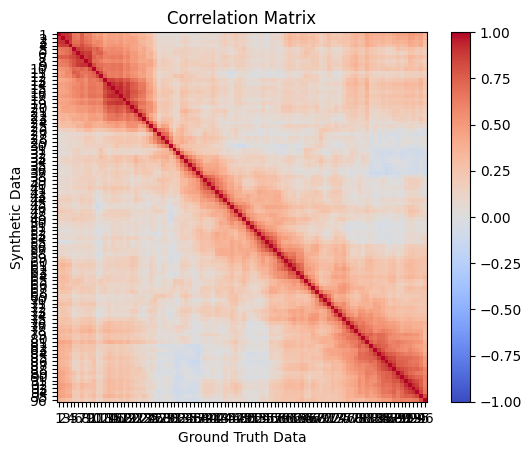

In [113]:
# Calculate the correlation coefficients between each pair of time series
corr_coeffs = np.corrcoef(features[0],rowvar=False)

# Plot the correlation matrix
fig, ax = plt.subplots()
im = ax.imshow(corr_coeffs, cmap='coolwarm', vmin=-1, vmax=1)

# Add axis labels and a colorbar
ax.set_xticks(np.arange(96))
ax.set_yticks(np.arange(96))
ax.set_xticklabels(np.arange(1, 96+1))
ax.set_yticklabels(np.arange(1, 96+1))
ax.set_title('Correlation Matrix')
fig.colorbar(im)
plt.show()

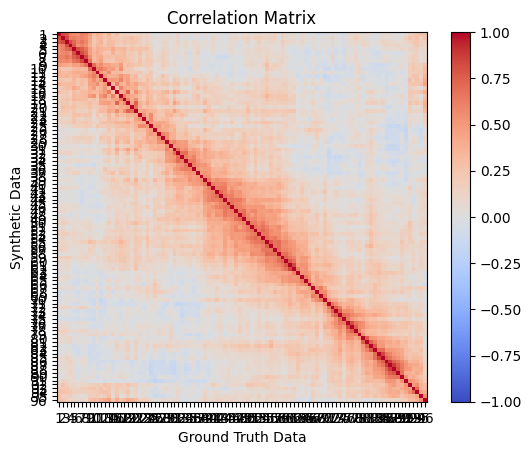

In [112]:
# Calculate the correlation coefficients between each pair of time series
corr_coeffs = np.corrcoef(generated[0],rowvar=False)

# Plot the correlation matrix
fig, ax = plt.subplots()
im = ax.imshow(corr_coeffs, cmap='coolwarm', vmin=-1, vmax=1)

# Add axis labels and a colorbar
ax.set_xticks(np.arange(96))
ax.set_yticks(np.arange(96))
ax.set_xticklabels(np.arange(1, 96+1))
ax.set_yticklabels(np.arange(1, 96+1))
ax.set_title('Correlation Matrix')
fig.colorbar(im)
plt.show()